In [1]:
#2D simulation of a wave propagating through inhomogeneous medium

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
#user parameters

N=np.array([512, 1024]) # size of grid z,x
u=np.array([0.1, 0.1]) #units z, x in lambda
NA=0.5 #NA of lens
RI=np.array([1.33, 2.0]) #refractive indices of turbid sample (we assume a binary RI-distribution for simplicity)

In [3]:
#creating real-space grid
x=np.arange(-N[1]/2,N[1]/2)*u[1]  #simulation window shows +/- 100 wavelengths in x
z=np.arange(0,N[0])*u[0]  #simulation window shows ~50 wavelengths in z
[X,Z]=np.meshgrid(x,z)

#creating k-space grid
uk=2*np.pi/u/N   #increment in frequency-space is 1/(size of grid in x-space); increment in k-space is 2*pi/(size of grid in x-space)
kx=np.arange(-N[1]/2,N[1]/2)*uk[1] 
kz=np.arange(0,N[0])*uk[0]
[Kx,Kz]=np.meshgrid(kx,kz)

Text(0.5,1,'RI distribution of sample')

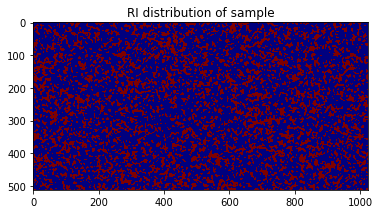

In [4]:
#defining random sample
tmp=np.random.random((N[0],N[1])) #array of random numbers with dimensions of N

#low-pass filtering of random sample (performed in k-space)

F_tmp=np.fft.fft2(tmp)  #fourier transform random array
sigma=(N[0]/10*u[0], N[1]/10*u[1])  # 10% of simulation region ~ 5x10 wavelengths in real space
F_filter=np.exp(-X**2/sigma[1]**2-(Z-N[0]*u[0]/2)**2/sigma[0]**2) #Gaussian LP filter function
tmp2=np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(F_filter*F_tmp))) #apply filter, undo shift to center spectrum on zero in k space
                                                                    #2d fft back to lambda space and shift center back to zero
sample=np.fft.ifftshift((tmp2/np.max(tmp2)>0.1)*(RI[1]-RI[0])+RI[0], 1) #undo shift to center on zero for X axis, and threshold normalized values to >0.1
plt.imshow(np.real(sample),cmap='jet')   #Plot real part of filtered random refractive indices
plt.title('RI distribution of sample')


In [5]:
def wavefront(d):
    '''defining input wavefront: a spherical, converging wave'''
    NA_geo=NA/1.33 #geometric NA of our objective lens
    # phase
    R=N[0]*u[0]*d #radius of curvature; define it such that focus lies at last layer
    phase = 2*np.pi*(np.sqrt(0j+R**2-(x)**2)-R)  # spherical phase
    
    # amplitude
    amp0=np.abs(x)<R*NA_geo #wave amplitude is 1 for x less than R*NA_geo
    sigma_amp=1 #we filter the amplitude a bit to make the edges less sharp
    amp_filter=np.exp(-(x)**2/sigma_amp**2)
    F_amp0=np.real(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(amp0))))
    amp=np.real(np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(F_amp0*amp_filter))))
#     plt.figure(1)
#     plt.plot(x,np.real(phase))
#     plt.title('input phase')
#     plt.figure(2)
#     plt.plot(x,amp)
#     plt.title('input amplitude')
    E=np.zeros(N,dtype='complex') #initializing field 
    E_in=np.fft.ifftshift(amp*np.exp(1j*phase))  #already apply ifftshift (loop later is faster)
    
    return E_in

In [6]:
E_in = wavefront(1)

In [7]:
#defining propagator for each refractive index 

RI=np.unique(sample) 
k = 2 * np.pi * RI/1.33 # k-vectors of light that traverses the different refractive indices, not accounting for objective NA here

def prop1():
    kx1=np.arange(-int(N[1]*3/4),int(N[1]*3/4))*uk[1] 
    prop = np.zeros((len(RI), int(N[1]*1.5)), dtype='complex')  # initializing propagators
    for q in range(len(RI)):
        prop[q, :] = np.fft.ifftshift(np.exp(1j * u[0] * np.sqrt(0j+k[q] ** 2 - kx1 ** 2)))
    return prop

def prop2():
    kx=np.arange(-N[1]/2,N[1]/2)*uk[1] 
    prop = np.zeros((len(RI), N[1]), dtype='complex')  # initializing propagators
    for q in range(len(RI)):
        prop[q, :] = np.fft.ifftshift(np.exp(1j * u[0] * np.sqrt(0j+k[q] ** 2 - kx ** 2)))
    return prop

In [8]:
#defining function which propagates the field through the specimen 

def fun_propagate(E_in,sample,prop, a):
    
    sample_test = sample=np.fft.fftshift(sample, 1)
    
    RI=np.unique(sample_test) #extract different RIs of sample
    N=sample_test.shape       #size of sample (and field)
    E=np.zeros(N,dtype='complex') #initializing field 
    Ek=np.zeros((len(RI),N[1]),dtype='complex') #init.
    mask=np.zeros((len(RI),N[0],N[1])) #initializing mask
    E[0,:]=E_in 
    
    #constructing binary masks for every RI
    for q in range(len(RI)):
        mask[q,:,:]=sample_test==RI[q] 
    
    #range that we need to calculate for simulation
    #propagation loop
    for m in range((N[0]-1)-4*a*(int(N[0]/8)-1)):
        
        for q in range(len(RI)):
            Ek[q,:]=np.fft.fft(E[m,:]*mask[q,m,:])*prop[q,:]  #for each RI: transform field to k-space and multiply with correct propagator
    
        E[m+1,:]=np.fft.ifft(sum(Ek,0)) #calculate next depth-slice of field
    
    return E

In [9]:
#first we propagate through a homogeneous sample
for q in range(len(RI)):
    prop[q, :] = np.fft.ifftshift(np.exp(1j * u[0] * np.sqrt(0j+k[q] ** 2 - kx ** 2)))

sample1=1.33*np.ones(N) 
E_in = wavefront(1)
E=fun_propagate(E_in,sample1,prop2(), 0)   #execute propagation 
    
plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E)**1,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.real(E[-1,:])**1))
plt.title('focus')
plt.xlabel('x')

NameError: name 'prop' is not defined

Text(0.5,0,'x')

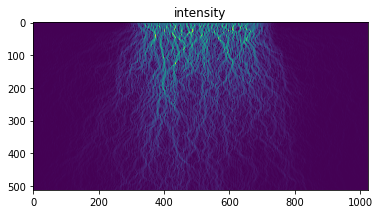

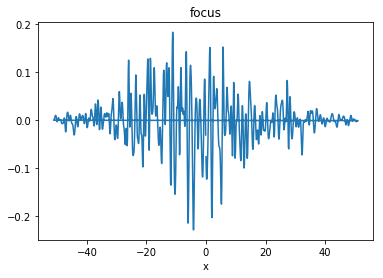

In [10]:
#now we propagate through the turbid sample 

E=fun_propagate(E_in,sample,prop2(), 0)   #execute propagation 
    
plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E)**1,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.real(E[-1,:])**1))
plt.title('focus')
plt.xlabel('x')

In [11]:
def grating1D(spacing, sample):
    "Creates a grating structure with frequency 1/spacing where 'spacing' is in units of wavelength"
    spacing1 = int(spacing/u[1])
    N = sample.shape
    N1 = N[1]
    tiles = int(N1/(spacing1*2)) #number of periods in grating
    remainder = N1 % (spacing1*2)
    a = np.zeros(spacing1)
    b = np.ones(spacing1)
    c = np.zeros(remainder)
    unit = np.concatenate((a,b))
    grating = np.concatenate((np.tile(unit, tiles), c))
  
    return grating

In [12]:
def step_beam(sample, grating_spacing, beam_step):
    '''Steps beam propagated through 'sample' across grating with spacing 'grating_spacing' with a step size 'beam_step' in units of wavelength.''' 
    global num_steps
    N = sample.shape
    #size of steps during beam scan
    m = int(beam_step/u[1])
    #number of steps in image
    num_steps = int(N[1]/(m*2)) 
    #create sample grating with spacing grating_spacing in units of wavelength
    grating = grating1D(grating_spacing, sample)
    plt.figure(0)
    plt.plot(grating)
    #pad E_in with zeros for propagation
    fill = np.zeros(int(N[1]/4))  
    E_in = wavefront(1)
    EinPadded = np.concatenate((fill, np.fft.fftshift(E_in), fill))
    E_scan = np.fft.ifftshift(EinPadded)
#     plt.figure(1)
#     plt.plot(np.real(EinPadded))
#     plt.plot(np.real(E_scan))
    #make array to hold each point of the scan 
    lines = np.zeros((num_steps, int(N[1]*1.5)))
    for q in range(num_steps):  
        #shift turbid sample at each step of scan
        samplePad0 = np.zeros((N[0], (m*q)))+min(sample[0])
        samplePad1 = np.zeros((N[0],(int(N[1]/2) - m*q )))+min(sample[0])
        samplePadded = np.concatenate((samplePad0, sample, samplePad1), axis = 1)
        #shift grating at each step of scan
        gratingPad0 = np.zeros((m*q))
        gratingPad1 = np.zeros(int(N[1]/2) - m*q )
        gratingPadded = np.concatenate((gratingPad0, grating, gratingPad1))
        #calculate beam profile for each step
        E = fun_propagate(E_scan,samplePadded,prop1(), 1)  #calculate electric field at focus modulated by sample
        beam_shifted = abs(E[227,:])**2  #Electric field from earlier calculation raised to 4th power for 2 photon excitation
        beam = np.fft.fftshift(beam_shifted)  
#         plt.figure(q+2, figsize=(10, 4))
#         plt.imshow(samplePadded)
#         plt.title('turbid sample')
#         plt.xlabel('x')
        plt.figure(m*2+q+2, figsize=(10, 4))
        plt.plot(beam)
        plt.plot(gratingPadded)
        plt.title('focus and grating')
        plt.xlabel('x')
#         plt.figure(q+m+2, figsize=(10, 4))
#         plt.imshow(np.fft.fftshift(abs(E)**1,1))
#         plt.title('Field')
#         plt.xlabel('x')
        lines[q,:] = beam * gratingPadded  
    image = np.sum(lines, axis = 1)

    return image

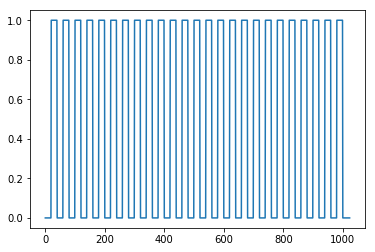

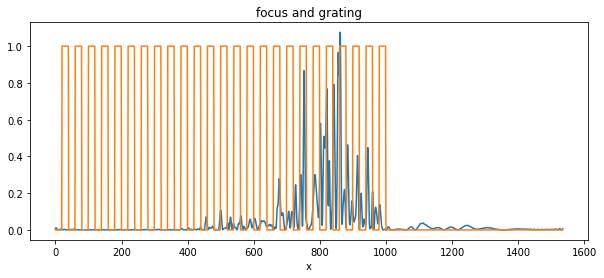

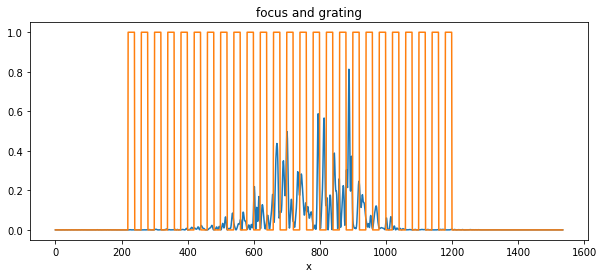

In [13]:
image = step_beam(sample, 2, 20)
image_pure = step_beam(sample1, 2, 0.2)
image_aberrated = step_beam(sample, 2, 0.2)

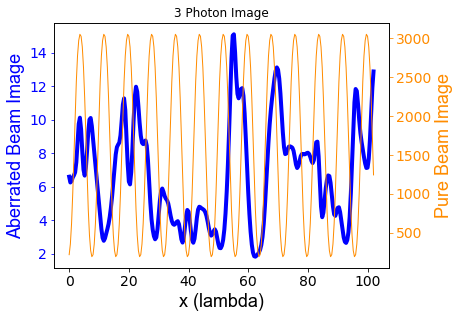

In [787]:
xmax = N[1]*u[1]
pixels = (xmax/num_steps)
xnew = np.arange(0, xmax, pixels)

fig, ax1 = plt.subplots(1,1,figsize=(6,4.5))
ax1.plot(xnew, image_aberrated, 'b', linewidth = 4)
ax1.set_ylabel('Aberrated Beam Image', color='b', fontsize =18, fontname = 'Arial')
ax1.tick_params('y', colors='b', labelsize = 14)
ax1.yaxis.set_label_position("left")
ax2 = ax1.twinx()
ax2.plot(xnew ,image_pure, 'darkorange', linestyle="-", linewidth = 1)
ax2.set_ylabel('Pure Beam Image', color='darkorange', fontsize = 18, fontname = 'Arial')
ax2.tick_params('y', colors='darkorange', labelsize = 14)
plt.title('3 Photon Image')
ax1.set_xlabel('x (lambda)', fontsize = 18, fontname = 'Arial')
ax1.tick_params('x', colors='k', labelsize = 14)

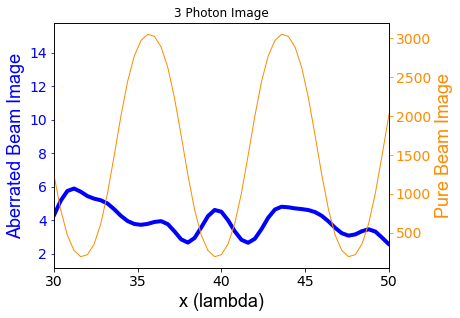

In [788]:
fig, ax1 = plt.subplots(1,1,figsize=(6,4.5))
ax1.plot(xnew, image_aberrated, 'b', linewidth = 4,zorder=0)
ax1.set_ylabel('Aberrated Beam Image', color='b', fontsize =18, fontname = 'Arial')
ax1.tick_params('y', colors='b', labelsize = 14)
ax1.yaxis.set_label_position("left")
# plt.ylim([0, 3])
ax2 = ax1.twinx()
ax2.plot(xnew ,image_pure, 'darkorange', linestyle="-", linewidth = 1)
ax2.set_ylabel('Pure Beam Image', color='darkorange', fontsize = 18, fontname = 'Arial')
ax2.tick_params('y', colors='darkorange', labelsize = 14)
plt.title('3 Photon Image')
plt.xlabel('x (lambda)')
plt.xlim([30, 50])
ax2.set_xlabel('x (lambda)', fontsize = 18, fontname = 'Arial')
ax1.set_xlabel('x (lambda)', fontsize = 18, fontname = 'Arial')
ax1.tick_params('x', colors='k', labelsize = 14)

In [14]:
plt.plot(np.fft.fft(image_aberrated))

NameError: name 'image_aberrated' is not defined

In [782]:
image_pure_3photon = image_pure.copy()
image_aberrated_3photon = image_aberrated.copy()